# Notebook is strictly wip at this point, experimenting with the pmdarima pipeline.Pipeline

## FIND THE SOURCE FOR YEO_JOHNSON PLUG THAT IN HERE

In [3]:
#### SOURCE https://alkaline-ml.com/pmdarima/auto_examples/preprocessing/example_date_featurizer.html#sphx-glr-auto-examples-preprocessing-example-date-featurizer-py

import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing


import cabi.etl.load as l
import cabi.etl.transform as t

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)



pmdarima version: 1.7.1


In [2]:
col = '2F'

In [8]:
series = l.load_counts(col)

In [9]:
series = series.rolling('6H').sum()

In [62]:
hourly = t.snap_to_interval(series, '1H')

In [63]:
hourly = hourly[(hourly.index >= '2020-04-15') & (hourly.index < '2020-06-01')]

In [54]:
hourly = hourly.reset_index()

In [55]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

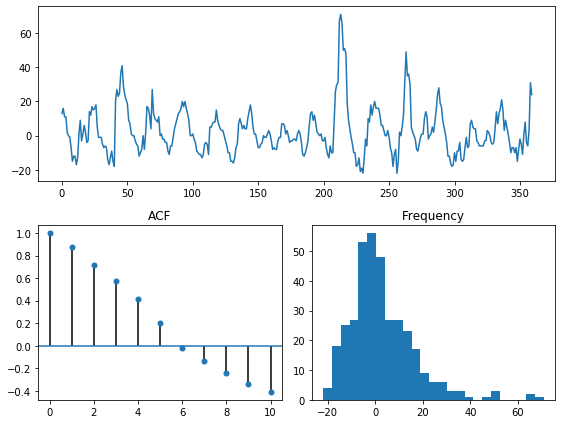

Head of generated exog features:
   DATE-WEEKDAY-0  DATE-WEEKDAY-1  DATE-WEEKDAY-2  DATE-WEEKDAY-3  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   DATE-WEEKDAY-4  DATE-WEEKDAY-5  DATE-WEEKDAY-6  
0               1               0               0  
1               1               0               0  
2               1               0               0  
3               1               0               0  
4               1               0               0  
Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 0, 2)(1, 0, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
 ARIMA(2,0,2)(1,0,1)[24] intercept   :

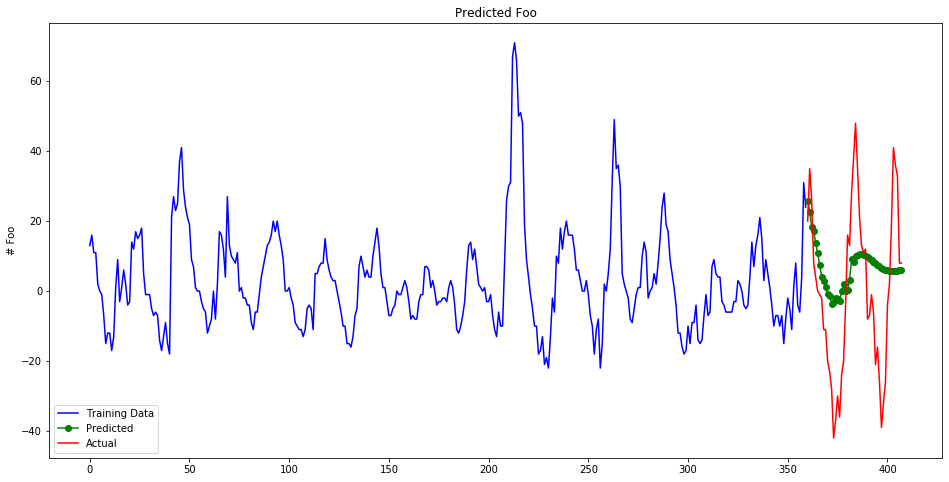

21.88197296452944
CPU times: user 22min 5s, sys: 16.3 s, total: 22min 22s
Wall time: 8min 10s


In [59]:
%%time

# Load the data and split it into separate pieces
y, X = hourly['2F'], hourly[['time']]
y_train, y_test, X_train, X_test = \
    model_selection.train_test_split(y, X, test_size=48)

# We can examine traits about the time series:
pm.tsdisplay(y_train, lag_max=10)

# We can see the ACF increases and decreases rather rapidly, which means we may
# need some differencing. There also does not appear to be an obvious seasonal
# trend.
n_diffs = arima.ndiffs(y_train, max_d=5)

# Here's what the featurizer will create for us:
date_feat = preprocessing.DateFeaturizer(
    column_name="time",  # the name of the date feature in the exog matrix
    with_day_of_week=True,
    with_day_of_month=False)



_, X_train_feats = date_feat.fit_transform(y_train, X_train)
print("Head of generated exog features:\n%s" % repr(X_train_feats.head()))

# We can plug this exog featurizer into a pipeline:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=True,
                              m=24
                             ))
])

pipe.fit(y_train, X_train)

# Plot our forecasts
forecasts = pipe.predict(exogenous=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
ax.set_title('Predicted Foo')
ax.set_ylabel('# Foo')

plt.show()

print(RMSE(y_test, forecasts))

# What next? Try combining different featurizers in your pipeline to enhance
# a model's predictive power.

In [60]:
print('DONE \n DONE \n DONE \n DONE \n')

DONE 
 DONE 
 DONE 
 DONE 



In [26]:
import pandas as pd
np.array(hourly).shape

(2937,)

In [27]:
X.shape

(2937,)

In [28]:
y.shape

(2937,)

In [29]:
X.reshape(-1,1)

AttributeError: 'DatetimeIndex' object has no attribute 'reshape'

In [44]:
y, X = load_date_example()
X

,date
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
...,...
322,2019-11-19
323,2019-11-20
324,2019-11-21
325,2019-11-22


In [36]:
y = hourly

In [37]:
y

time
2020-04-01 00:00:00    0.0
2020-04-01 01:00:00    0.0
2020-04-01 02:00:00    0.0
2020-04-01 03:00:00    0.0
2020-04-01 04:00:00   -2.0
                      ... 
2020-08-01 04:00:00    0.0
2020-08-01 05:00:00    0.0
2020-08-01 06:00:00    0.0
2020-08-01 07:00:00    0.0
2020-08-01 08:00:00    0.0
Freq: H, Name: 2F, Length: 2937, dtype: float64

In [38]:
y.reset_index()

,time,2F
0,2020-04-01 00:00:00,0.0
1,2020-04-01 01:00:00,0.0
2,2020-04-01 02:00:00,0.0
3,2020-04-01 03:00:00,0.0
4,2020-04-01 04:00:00,-2.0
...,...,...
2932,2020-08-01 04:00:00,0.0
2933,2020-08-01 05:00:00,0.0
2934,2020-08-01 06:00:00,0.0
2935,2020-08-01 07:00:00,0.0


In [39]:
y

time
2020-04-01 00:00:00    0.0
2020-04-01 01:00:00    0.0
2020-04-01 02:00:00    0.0
2020-04-01 03:00:00    0.0
2020-04-01 04:00:00   -2.0
                      ... 
2020-08-01 04:00:00    0.0
2020-08-01 05:00:00    0.0
2020-08-01 06:00:00    0.0
2020-08-01 07:00:00    0.0
2020-08-01 08:00:00    0.0
Freq: H, Name: 2F, Length: 2937, dtype: float64

## Testing the Fourier Feature

In [65]:
from pmdarima import preprocessing as ppc

Performing stepwise search to minimize aic
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3861.366, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4734.392, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3975.284, Time=0.79 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4254.095, Time=0.95 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3889.424, Time=3.87 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3925.279, Time=3.84 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=3924.272, Time=4.67 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=4.56 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3934.355, Time=2.79 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3880.904, Time=4.75 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3925.941, Time=4.42 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=inf, Time=5.14 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3854.698, Time=4.64 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3885.457, Time=4.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3

/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


[ 1.76564070e+01  9.61022578e+00  1.61098658e+00 -3.69381530e-01
 -1.94109045e+00 -2.95701247e+00 -3.36793579e+00 -4.04529414e+00
 -3.71462368e+00 -3.58289579e+00 -2.08669823e+00 -1.64299112e+00
 -1.22527488e+00  8.61681869e-03  1.38152510e+00  1.07635321e+00
 -5.21598822e-01  1.47391043e+00  1.88624154e+00  3.53084956e+00
  6.20568209e+00  6.75330648e+00  8.79889558e+00  9.15917616e+00
  9.16216812e+00  7.36636051e+00  4.45305599e+00  3.99274884e+00
  1.49359344e+00 -8.69900799e-01 -2.21812157e+00 -3.57912078e+00
 -3.84618336e+00 -4.11214929e+00 -2.70114244e+00 -2.10912976e+00
 -1.48048710e+00 -8.14455627e-02  1.39372998e+00  1.14511789e+00
 -4.31466195e-01  1.55554567e+00  1.94087419e+00  3.55542069e+00
  6.20783050e+00  6.74323897e+00  8.78458244e+00  9.14563177e+00
  9.15215880e+00  7.36085421e+00  4.45153794e+00  3.99384981e+00
  1.49584515e+00 -8.67578441e-01 -2.21631304e+00 -3.57802646e+00
 -3.84575540e+00 -4.11220682e+00 -2.70146080e+00 -2.10951393e+00
 -1.48081401e+00 -8.16588

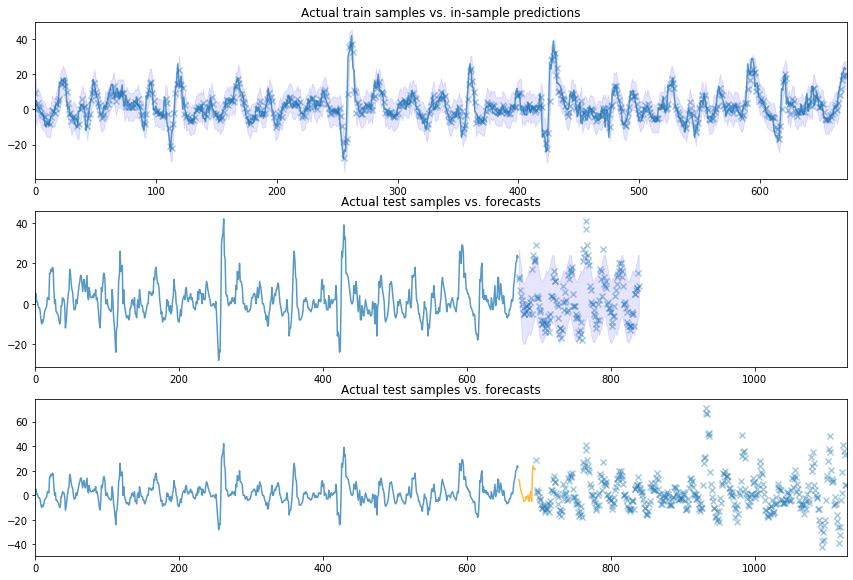

CPU times: user 1min 44s, sys: 541 ms, total: 1min 44s
Wall time: 1min 22s


In [69]:
%%time

# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=24, k=11)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              start_p=4, max_p=10,
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

# Let's take a look at the actual vs. the predicted values:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

# Visualize goodness of fit
in_sample_preds, in_sample_confint = \
    pipe.predict_in_sample(exogenous=None, return_conf_int=True)

print(pipe.summary())

n_train = train.shape[0]

x0 = np.arange(n_train)
axes[0].plot(x0, train, alpha=0.75)
axes[0].scatter(x0, in_sample_preds, alpha=0.4, marker='x')
axes[0].fill_between(x0, in_sample_confint[:, 0], in_sample_confint[:, 1],
                     alpha=0.1, color='b')
axes[0].set_title('Actual train samples vs. in-sample predictions')
axes[0].set_xlim((0, x0.shape[0]))

# Visualize actual + predicted
x1 = np.arange(n_train + preds.shape[0])
axes[1].plot(x1[:n_train], train, alpha=0.75)
# axes[1].scatter(x[n_train:], preds, alpha=0.4, marker='o')
axes[1].scatter(x1[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
axes[1].fill_between(x1[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
axes[1].set_title('Actual test samples vs. forecasts')
axes[1].set_xlim((0, hourly.shape[0]))

# We can also call `update` directly on the pipeline object, which will update
# the intermittent transformers, where necessary:
newly_observed, still_test = test[:24], test[24:]
pipe.update(newly_observed, maxiter=10)

# Calling predict will now predict from newly observed values
new_preds = pipe.predict(still_test.shape[0])
print(new_preds)

x2 = np.arange(hourly.shape[0])
n_trained_on = n_train + newly_observed.shape[0]

axes[2].plot(x2[:n_train], train, alpha=0.75)
axes[2].plot(x2[n_train: n_trained_on], newly_observed, alpha=0.75, c='orange')
# axes[2].scatter(x2[n_trained_on:], new_preds, alpha=0.4, marker='o')
axes[2].scatter(x2[n_trained_on:], still_test, alpha=0.4, marker='x')
axes[2].set_title('Actual test samples vs. forecasts')
axes[2].set_xlim((0, hourly.shape[0]))

plt.show()

